In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/wind-power-forecasting/Turbine_Data.csv


## Wind Power Forecasting

In this notebook we're going to  to predict the wind power that could be generated from the windmill for the next 15 days.  We'll use ARIMA model for forecasting. 

Let's start

In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../input/wind-power-forecasting/Turbine_Data.csv',parse_dates=["Unnamed: 0"])
df.shape

(118224, 22)

In [4]:
df=df.dropna()
df=df.reset_index()
df.shape


(32728, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32728 entries, 0 to 32727
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype              
---  ------                        --------------  -----              
 0   index                         32728 non-null  int64              
 1   Unnamed: 0                    32728 non-null  datetime64[ns, UTC]
 2   ActivePower                   32728 non-null  float64            
 3   AmbientTemperatue             32728 non-null  float64            
 4   BearingShaftTemperature       32728 non-null  float64            
 5   Blade1PitchAngle              32728 non-null  float64            
 6   Blade2PitchAngle              32728 non-null  float64            
 7   Blade3PitchAngle              32728 non-null  float64            
 8   ControlBoxTemperature         32728 non-null  float64            
 9   GearboxBearingTemperature     32728 non-null  float64            
 10  GearboxOilTemperature         3272

In [6]:
df['DateTime'] = df['Unnamed: 0'] 
df.drop(['Unnamed: 0','index'], axis=1, inplace=True)

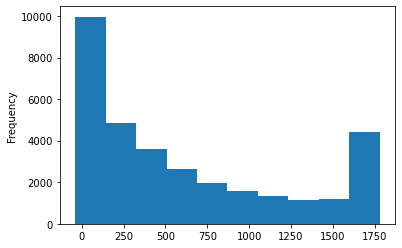

In [7]:
df.ActivePower.plot.hist()

## Parsing dates
When working with time series data, it's a good idea to make sure any date data is the format of a datetime object (a Python data type which encodes specific information about dates).

In [8]:
# Add datetime parameters 
df['DateTime'] = pd.to_datetime(df['DateTime'], 
 format = '%Y-%m-%dT%H:%M:%SZ', 
 errors = 'coerce')

df['year'] = df['DateTime'].dt.year
df['month'] = df['DateTime'].dt.month
df['day'] = df['DateTime'].dt.day
df['hour'] = df['DateTime'].dt.hour
df['minute'] = df['DateTime'].dt.minute

In [9]:
# Drop original DateTime column
df.drop('DateTime', axis=1, inplace= True)

In [10]:
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed,year,month,day,hour,minute
0,-7.851491,39.308243,47.154927,45.736893,43.699357,43.699357,0.0,58.852307,56.782879,68.210284,...,0.672715,2.0,G01,44.80,2.212693,2019,5,6,14,10
1,-5.565284,39.206277,40.058399,41.260297,41.260230,41.260230,0.0,48.911180,56.033333,68.229411,...,0.508198,2.0,G01,49.00,2.130019,2019,5,6,14,30
2,-5.549332,39.194184,46.500652,39.576077,39.576122,39.576122,0.0,56.859428,55.873937,85.012009,...,0.715614,2.0,G01,61.50,2.347810,2019,5,6,14,50
3,-5.768376,38.992667,46.419196,47.399521,48.299502,48.299502,0.0,56.761226,55.807661,63.945036,...,0.550434,129.0,G01,93.25,2.161460,2019,5,6,15,0
4,-5.091456,38.686212,46.280597,50.363603,50.363691,50.363691,0.0,56.483241,55.451512,21.339981,...,0.251628,282.0,G01,138.50,1.913490,2019,5,6,15,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32723,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,9.234004,2.0,G01,178.00,3.533445,2020,3,30,23,10
32724,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,9.229370,2.0,G01,178.00,3.261231,2020,3,30,23,20
32725,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,9.236802,2.0,G01,178.00,3.331839,2020,3,30,23,30
32726,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,9.237374,2.0,G01,190.00,3.284468,2020,3,30,23,40


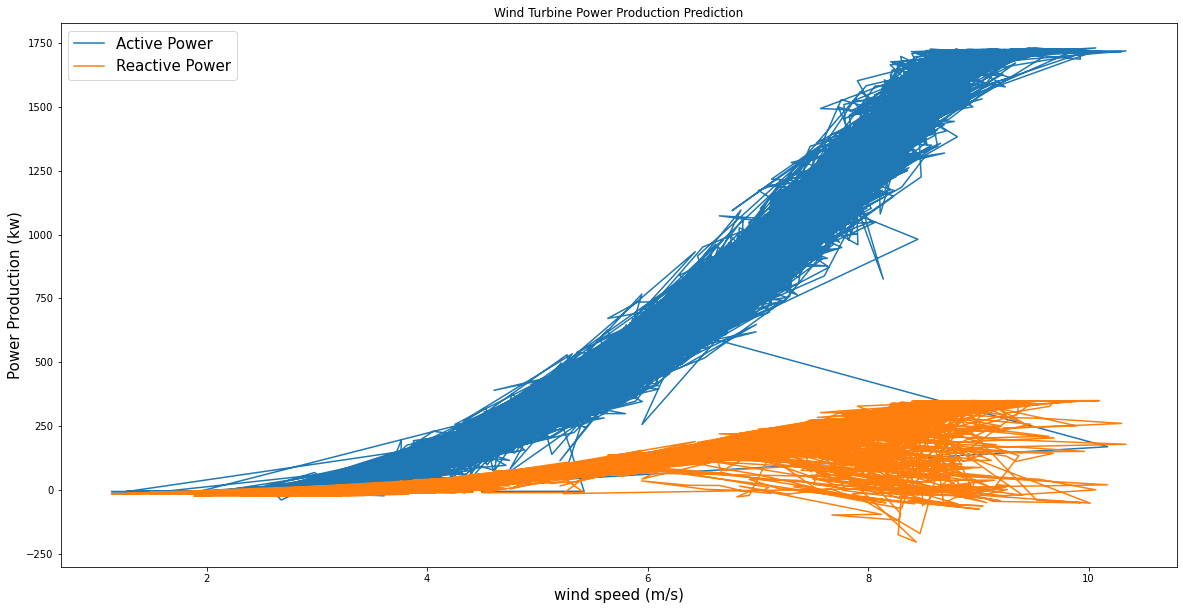

In [11]:
def plot_wind_power(y):
    plt.figure(figsize=(20,10))
    df1=df[df['year']==y]
    plt.plot(df1['WindSpeed'],df1['ActivePower'],label="Active Power")
    plt.plot(df1['WindSpeed'],df1['ReactivePower'],label="Reactive Power")
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()
    
plot_wind_power(2020)

In [12]:
df.columns

Index(['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'ControlBoxTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
       'WindDirection', 'WindSpeed', 'year', 'month', 'day', 'hour', 'minute'],
      dtype='object')

In [13]:
from lightgbm import LGBMClassifier
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBClassifier
from xgboost.sklearn import XGBRegressor
import xgboost as xgb

In [14]:
ftrain = ['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'ControlBoxTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition','RotorRPM', 'TurbineStatus',
       'WindDirection', 'WindSpeed']

def Definedata():
    # define dataset
    data2 = df[ftrain]
    X = data2.drop(columns=['ActivePower']).values
    y = data2['ActivePower'].values
    #lab_enc = preprocessing.LabelEncoder()
    #y = lab_enc.fit_transform(y0)
    return X, y

In [15]:
def Models(models):
    
    model = models
    X, y = Definedata()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    y_total = model.predict(X)
    
    print("\t\tError Table")
    print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Accuracy on Traing set   : ', model.score(X_train,y_train))
    print('Accuracy on Testing set  : ', model.score(X_test,y_test))
    return y_total,y,y_pred,y_test

def Featureimportances(models):
    model = models
    model.fit(X_train,y_train)
    importances = model.feature_importances_
    features = df_test.columns[:9]
    imp = pd.DataFrame({'Features': ftest, 'Importance': importances})
    imp['Sum Importance'] = imp['Importance'].cumsum()
    imp = imp.sort_values(by = 'Importance')
    return imp

def Graph_prediction(y_actual, y_predicted):
    y = y_actual
    y_total = y_predicted
    #TP = df['Theoretical_Power_Curve (KWh)']
    number = len(df['WindSpeed'])
    aa=[x for x in df['WindSpeed']]
    plt.figure(figsize=(20,7)) 
    plt.plot(aa, y[:number], 'o', label='Real Power')
    plt.plot(aa, y_total[:number], 'x', label='Predicted Power')
    #plt.plot(aa, TP[:number], '.', label='theoretical_power_curve (kwh)')
    
    plt.xlabel('wind speed (m/s)', size=15)
    plt.ylabel('Power Production (kw)', size=15)
    plt.title('Wind Turbine Power Production Prediction')
    plt.legend(fontsize=15)
    plt.show()

		Error Table
Mean Absolute Error      :  24.004187051500615
Mean Squared  Error      :  1808.6074176781574
Root Mean Squared  Error :  42.52772528219864
Accuracy on Traing set   :  0.9965436019565695
Accuracy on Testing set  :  0.9949040370457902


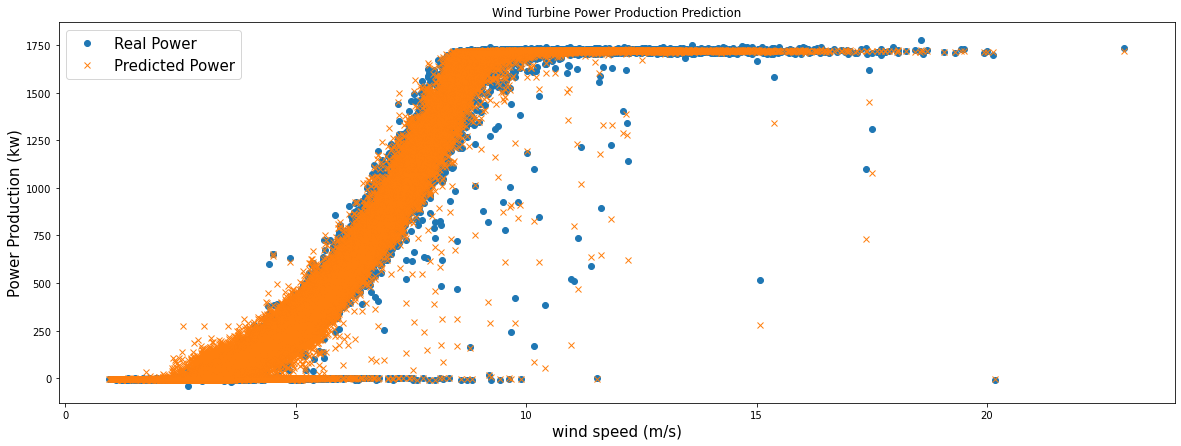

In [16]:
y_predicted, y_actual,pred,real  = Models(KNeighborsRegressor(n_neighbors=7))
Graph_prediction(y_actual, y_predicted)


		Error Table
Mean Absolute Error      :  18.864247434198354
Mean Squared  Error      :  1204.0214119555928
Root Mean Squared  Error :  34.69901168557388
Accuracy on Traing set   :  1.0
Accuracy on Testing set  :  0.996607528836038


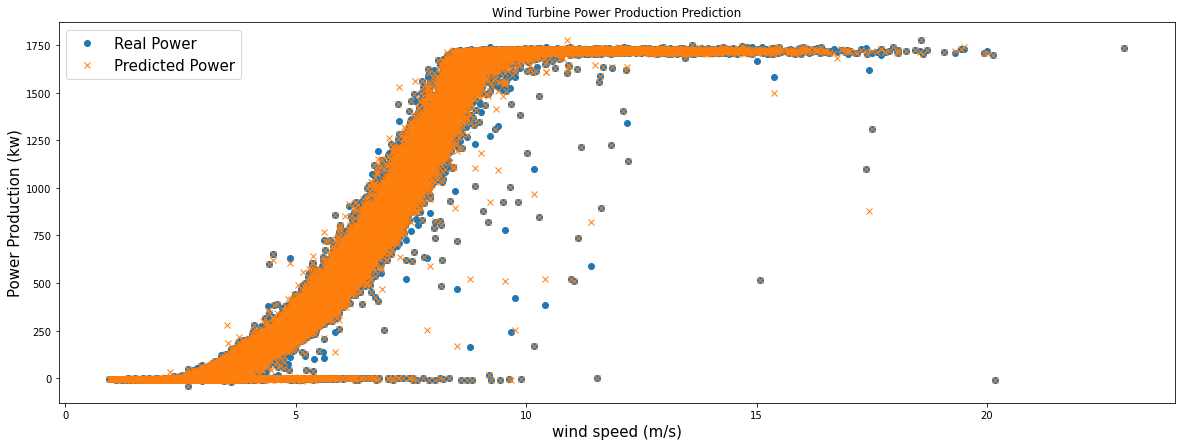

In [17]:
y_predicted, y_actual,pred,real  = Models(DecisionTreeRegressor())
Graph_prediction(y_actual, y_predicted)

		Error Table
Mean Absolute Error      :  71.59970121020352
Mean Squared  Error      :  13529.488311099456
Root Mean Squared  Error :  116.31632865208331
Accuracy on Traing set   :  0.9601909291154652
Accuracy on Testing set  :  0.961879084123581


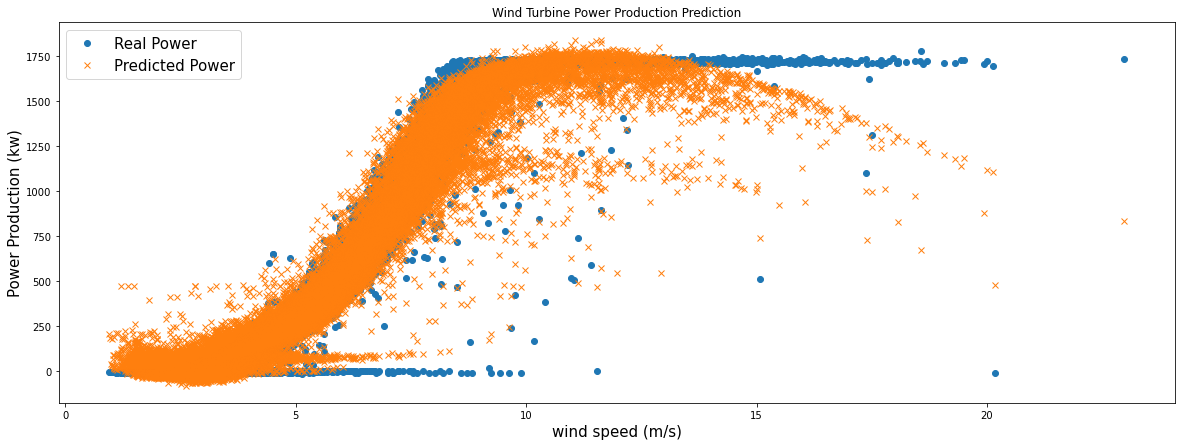

In [18]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
n_samples, n_features = 10, 5
rng = np.random.RandomState(0)
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
y_predicted, y_actual,pred,real  = Models(regr)
Graph_prediction(y_actual, y_predicted)

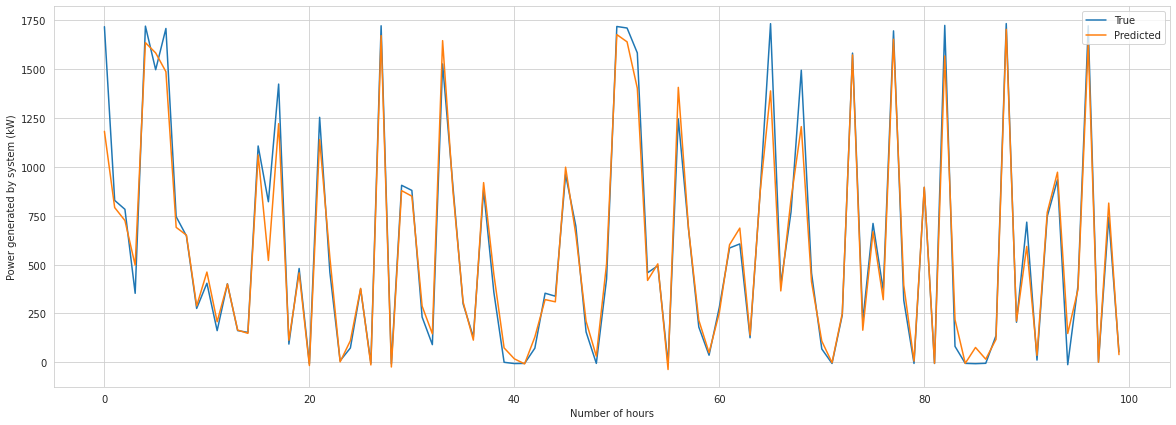

In [19]:
# line plot of observed vs predicted
import seaborn as sns
sns.set_style("whitegrid")
plt.figure(figsize=(20,7))
plt.plot(real[200:300], label="True")
plt.plot(pred[200:300], label="Predicted")
plt.legend(loc='upper right')
plt.xlabel("Number of hours")
plt.ylabel("Power generated by system (kW)")
plt.show()